header

# Introduction

## Business case

narrative text. be sure to look at the paper based on this dataset and cite it.

## Custom functions

In [0]:
# Define a function to print selected model metrics
def print_metrics(y_train, y_pred):
    acc_score = accuracy_score(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)
    class_report = classification_report(y_train, y_pred)
    print('Training accuracy:', acc_score)
    print('-------')
    print('Confusion matrix:')
    print(conf_matrix)
    print('-------')
    print('Classification report:')
    print(class_report)


In [0]:
# Define a function to visualize feature importances
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), range(1, n_features+1)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature (Component)")
    plt.title('Feature Importances')

In [0]:
# Define a function to calculate AUC and plot ROC curve
def roc_it(y_test, y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))

    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();

    print('AUC: {}'.format(auc(fpr, tpr)))

## Load and clean data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
# Get the data
df = pd.read_table("covtype.data", sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# Generate column names for the 40 soil type columns
soil_types = []
for n in range(1, 41):
    str_n = str(n)
    name = 'Soil_Type_' + str_n
    soil_types.append(name)
    
print(soil_types)

['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40']


In [4]:
# Name the columns
colnames = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
            'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
            'Hor_Dist_Fire', 'WA_1', 'WA_2', 'WA_3', 'WA_4', 'Soil_Type_1', 
            'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 
            'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 
            'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 
            'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 
            'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 
            'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 
            'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 
            'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 
            'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 
            'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40', 'Cover_Type',]
df.columns = colnames
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation         581012 non-null int64
Aspect            581012 non-null int64
Slope             581012 non-null int64
Hor_Dist_Hyd      581012 non-null int64
Ver_Dist_Hyd      581012 non-null int64
Hor_Dist_Road     581012 non-null int64
Hillshade_9am     581012 non-null int64
Hillshade_noon    581012 non-null int64
Hillshade_3pm     581012 non-null int64
Hor_Dist_Fire     581012 non-null int64
WA_1              581012 non-null int64
WA_2              581012 non-null int64
WA_3              581012 non-null int64
WA_4              581012 non-null int64
Soil_Type_1       581012 non-null int64
Soil_Type_2       581012 non-null int64
Soil_Type_3       581012 non-null int64
Soil_Type_4       581012 non-null int64
Soil_Type_5       581012 non-null int64
Soil_Type_6       581012 non-null int64
Soil_Type_7       581012 non-null int64
Soil_Type_8       581012 non-null int64
Soil_Type

In [5]:
# Check class balance
df.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

## EDA

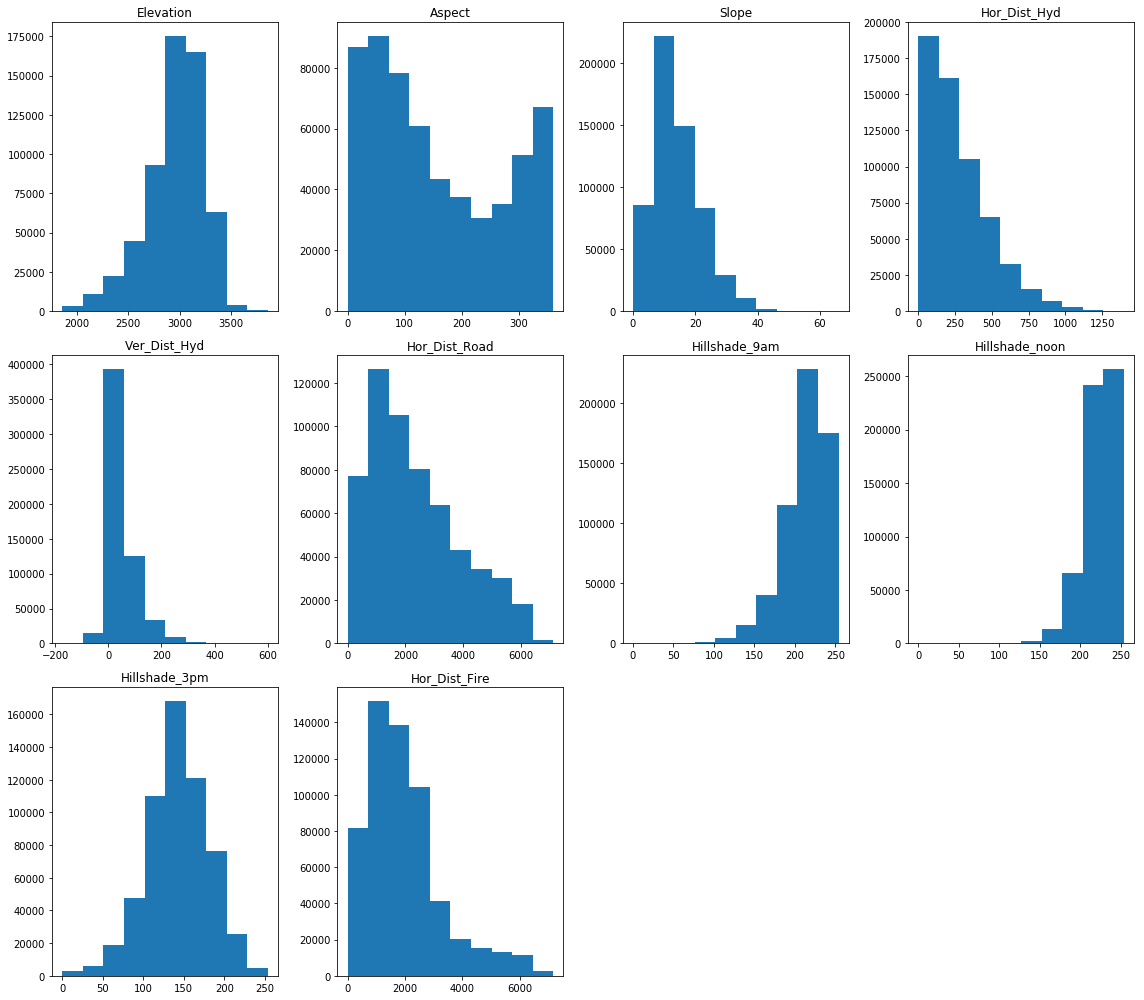

In [6]:
# Visualize distributions of continuous variables
to_hist = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
           'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
           'Hor_Dist_Fire']

plt.figure(figsize=(16,14))
for idx, col in enumerate(to_hist):
    plt.subplot(3, 4, idx+1)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout();


# Preprocessing

## Train-validation-test split

In [7]:
# Create training, validation, and test datasets
y = df['Cover_Type']
X = df.drop('Cover_Type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=1,
                                                stratify=y_test)

In [12]:
# Examine shapes of the subsets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(464809, 54) (464809,)
(58101, 54) (58101,)
(58102, 54) (58102,)


## Resampling and scaling

In [13]:
# Concatenate X_train and y_train for resampling
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
450015,3250,35,4,534,212,2969,219,231,148,3161,...,0,0,0,0,0,0,0,0,0,1
127010,2580,61,20,30,-1,1061,232,193,85,553,...,0,0,0,0,0,0,0,0,0,1
247694,2216,41,38,384,251,424,194,129,40,295,...,0,0,0,0,0,0,0,0,0,3
548749,3166,181,17,242,61,3252,224,248,152,630,...,0,0,1,0,0,0,0,0,0,2
29431,2900,296,25,210,92,5076,142,223,218,4763,...,0,0,0,0,0,0,0,0,0,1


In [14]:
len(df_train)

464809

In [15]:
# Check for class imbalance
df_train.Cover_Type.value_counts()

2    226640
1    169472
3     28603
7     16408
6     13894
5      7594
4      2198
Name: Cover_Type, dtype: int64

In [16]:
# Subset the cover types
cover_1 = df_train[df_train.Cover_Type == 1]
cover_2 = df_train[df_train.Cover_Type == 2]
cover_3 = df_train[df_train.Cover_Type == 3]
cover_4 = df_train[df_train.Cover_Type == 4]
cover_5 = df_train[df_train.Cover_Type == 5]
cover_6 = df_train[df_train.Cover_Type == 6]
cover_7 = df_train[df_train.Cover_Type == 7]

In [17]:
# Sample the cover type subsets
cover_1 = cover_1.sample(16408, random_state=1)
cover_2 = cover_2.sample(16408, random_state=1)
cover_3 = cover_3.sample(16408, random_state=1)

In [18]:
# Check that sampling was successful
len(cover_1)

16408

In [19]:
# Concatenate the subsets into one DataFrame
sample = pd.concat([cover_1, cover_2, cover_3, cover_4, cover_5, cover_6, 
                    cover_7], axis=0, ignore_index=True)
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89318 entries, 0 to 89317
Data columns (total 55 columns):
Elevation         89318 non-null int64
Aspect            89318 non-null int64
Slope             89318 non-null int64
Hor_Dist_Hyd      89318 non-null int64
Ver_Dist_Hyd      89318 non-null int64
Hor_Dist_Road     89318 non-null int64
Hillshade_9am     89318 non-null int64
Hillshade_noon    89318 non-null int64
Hillshade_3pm     89318 non-null int64
Hor_Dist_Fire     89318 non-null int64
WA_1              89318 non-null int64
WA_2              89318 non-null int64
WA_3              89318 non-null int64
WA_4              89318 non-null int64
Soil_Type_1       89318 non-null int64
Soil_Type_2       89318 non-null int64
Soil_Type_3       89318 non-null int64
Soil_Type_4       89318 non-null int64
Soil_Type_5       89318 non-null int64
Soil_Type_6       89318 non-null int64
Soil_Type_7       89318 non-null int64
Soil_Type_8       89318 non-null int64
Soil_Type_9       89318 non-null 

In [20]:
# Confirm that 6 of the 7 classes are balanced
sample.Cover_Type.value_counts()

7    16408
3    16408
2    16408
1    16408
6    13894
5     7594
4     2198
Name: Cover_Type, dtype: int64

In [21]:
# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=3)
                                                 
y_for_smote = sample['Cover_Type']
X_for_smote = sample.drop('Cover_Type', axis=1)

X_smote, y_smote = smote.fit_resample(X_for_smote, y_for_smote)

# Check count of each class
Counter(y_smote)

Counter({1: 16408, 2: 16408, 3: 16408, 4: 16408, 5: 16408, 6: 16408, 7: 16408})

In [22]:
# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_smote)
X_train = pd.DataFrame(X_train)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
# Check the results
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,...,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000,114856.000000
mean,0.444131,0.433975,0.306512,0.164121,0.296440,0.244005,0.837319,0.790768,0.529475,0.214838,...,0.020756,0.042862,0.040842,0.001680,0.007174,0.000453,0.002011,0.048139,0.044499,0.028627
std,0.209522,0.304804,0.155844,0.150671,0.085271,0.190128,0.120740,0.135087,0.182158,0.156485,...,0.142568,0.202548,0.197926,0.040958,0.084397,0.021273,0.044802,0.214060,0.206202,0.166757
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.256885,0.180556,0.185185,0.048201,0.232168,0.106670,0.771654,0.715976,0.417323,0.103896,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.445669,0.347222,0.277778,0.129496,0.269930,0.186602,0.866142,0.810651,0.543307,0.179701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.623435,0.719444,0.407407,0.237410,0.335664,0.324563,0.929134,0.887574,0.657480,0.281621,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


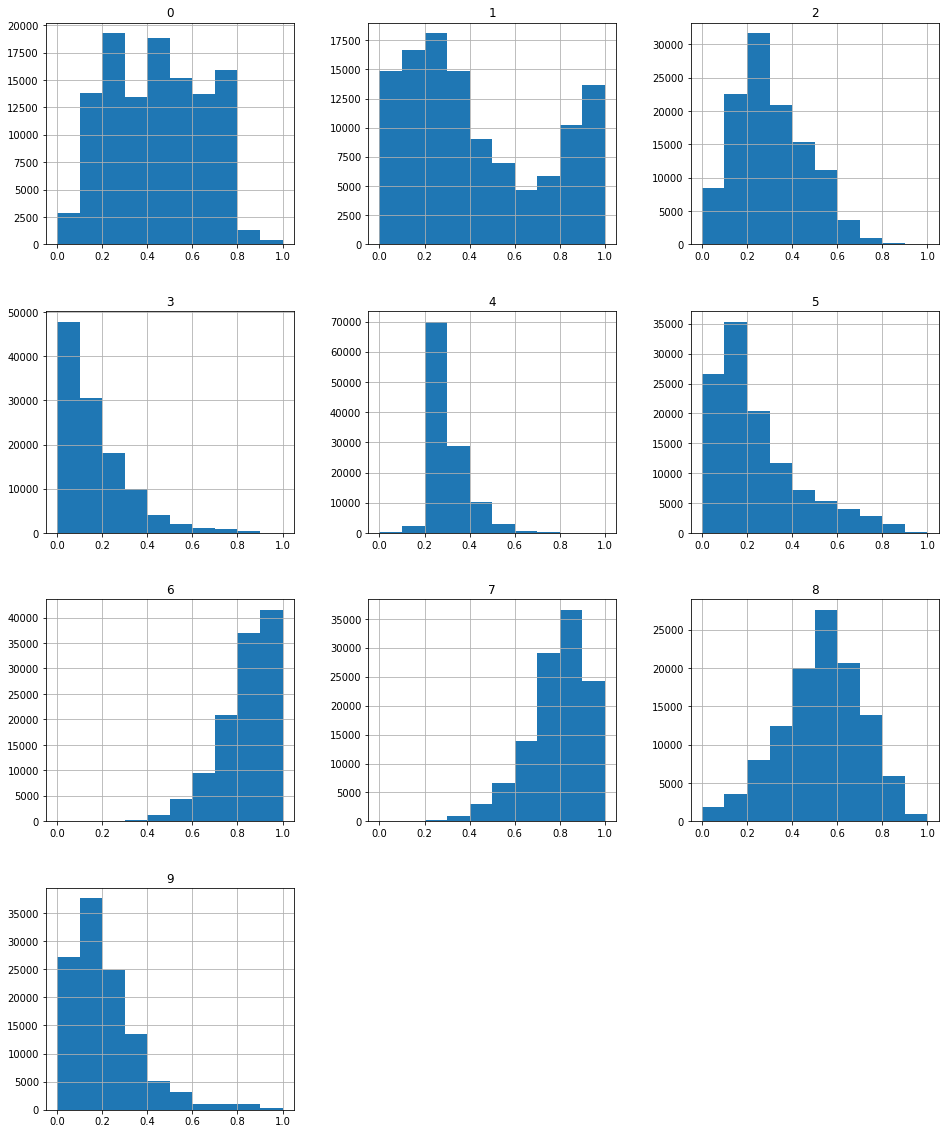

In [25]:
# Visualize the distributions again
X_train.loc[:,:9].hist(figsize=(16, 20));

## PCA

Principal Components Analysis takes the features we have and tries to combine them in ways that maximize the amount of variance the components can explain in the data. For datasets like the one I'm working with here, where there are lots of features, PCA can help us avoid the negative effects of having numerous features while still allowing us to account for as much variance as possible. For my analysis below, I aim to find a number of components that will explain at least 80% of the variance in the data.

First, let's see how much variance we can explain with a wide range of components. If any of these look promising, we can drill down further.

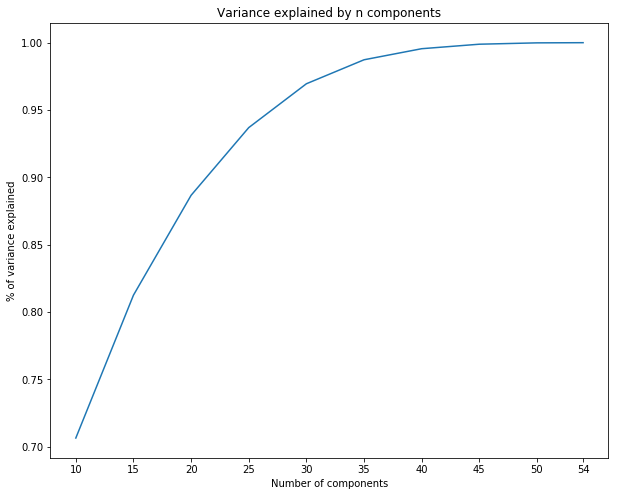

In [26]:
# Try several numbers of components to explain 80% of variance
comps = [10, 15, 20, 25, 30, 35, 40, 45, 50, 54]
var_sums = []
for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit_transform(X_train)
    var_sums.append(np.sum(pca.explained_variance_ratio_))
    
# Visualize results
plt.figure(figsize=(10,8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([10, 15, 20, 25, 30, 35, 40, 45, 50, 54])
plt.show();

In [27]:
# View the % variance explained for each number of components
display(list(zip(comps, var_sums)))

[(10, 0.7065035574909448),
 (15, 0.8125587761323032),
 (20, 0.8867075382086652),
 (25, 0.9369596880275936),
 (30, 0.9695106924934629),
 (35, 0.9873158588769906),
 (40, 0.9955309417189532),
 (45, 0.9988692434769496),
 (50, 0.9998719319153926),
 (54, 0.9999999999999998)]

From the plot and the list above, it's clear that we could explain over 80% of the variance in the data with 15 components (out of a possible 54). Using fewer features/components will help us avoid overfitting on the training data, but at the expense of a little bit of accuracy. I think it's a worthwhile trade, so from here onward I will use a transformed version of the dataset with 15 components for developing my models.

In [28]:
# Transform the dataset to have 15 principal components
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
np.sum(pca.explained_variance_ratio_)

0.8125571189239493

In [29]:
X_val_pca = pca.transform(X_val)

This transformation will form part of the final pipeline.

## Save preprocessed training and validation datasets

### Save copy of the training set

In [30]:
# Save the clean dataset for easier access later
y_train = pd.DataFrame(y_smote, columns=['Cover_Type'])
X_train = pd.DataFrame(X_train_pca)
sample_to_save = pd.concat([X_train, y_train], axis=1)
sample_to_save.to_csv('trees.csv')

### Save a copy of the validation set

In [31]:
y_val = pd.DataFrame(y_val, columns=['Cover_Type'])
y_val.reset_index(inplace=True)
y_val.drop('index', axis=1, inplace=True)

In [32]:
X_val = pd.DataFrame(X_val_pca)

In [33]:
val_to_save = pd.concat([X_val, y_val], axis=1, ignore_index=True)
len(val_to_save)

58101

In [34]:
val_to_save.to_csv('trees_val.csv')

# Shortcut: preprocessed data

### Reconstitute training and validation sets

In [16]:
sample = pd.read_csv('trees.csv')
sample.drop('Unnamed: 0', axis=1, inplace=True)
sample.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,Cover_Type
0,-0.109499,1.164250,0.166353,0.005914,-0.577643,-0.199181,-0.012353,0.023821,0.011069,-0.015904,0.035054,0.011001,0.037933,0.011919,0.066494,-0.110838,-0.077705,-0.043333,-0.006033,0.044633,-0.071194,-0.227052,0.013112,-0.036236,0.019265,0.093228,-0.131848,-0.175866,0.116097,0.033015,-0.021008,-0.039985,0.004825,-0.000292,0.010841,0.003256,-0.017034,-0.008738,0.002672,0.045033,1
1,-0.041592,1.140934,-0.061292,0.212198,-0.540963,-0.142123,0.071379,-0.061710,0.071147,-0.097264,0.108512,0.070737,0.056302,-0.030619,0.164041,-0.239611,-0.113499,-0.119156,0.038746,0.011222,0.051530,0.011849,0.087537,-0.186157,0.010255,0.062481,-0.117854,0.017835,0.015643,-0.009521,-0.022076,0.030818,0.048077,-0.011367,0.040806,0.003784,0.038351,0.050673,0.111306,0.031296,1
2,-0.671663,-0.237555,-0.233301,0.059341,0.192650,-0.077593,-0.367639,0.794701,0.070582,-0.090325,-0.143198,0.055467,-0.145586,-0.161835,0.098309,-0.105382,0.029873,-0.215819,0.140515,0.019127,0.068240,-0.075320,-0.030237,0.113086,-0.022895,-0.042838,0.045154,0.094059,0.095231,-0.063344,-0.058291,0.016579,0.073403,-0.005546,-0.011325,0.002119,0.006053,-0.023987,-0.000069,0.024012,1
3,-0.090224,1.095624,0.605992,-0.218132,-0.569790,0.010645,0.264100,-0.039178,0.035517,-0.124097,0.040652,0.044695,0.044115,-0.022164,0.109353,-0.148134,-0.064870,-0.099784,0.047233,0.004234,0.116093,0.062642,-0.075440,0.000807,-0.096711,-0.049878,-0.012402,0.072863,-0.019563,-0.027850,-0.015516,0.037963,0.031902,-0.016969,-0.056497,-0.022879,0.046491,0.042869,0.032362,0.045994,1
4,-0.717021,-0.346657,-0.191363,0.000991,-0.014794,-0.159953,-0.087454,-0.023365,-0.303085,-0.104132,0.532805,-0.516580,-0.254636,0.054687,-0.188519,-0.208302,0.167058,-0.003995,-0.016679,-0.046422,0.049062,-0.010062,-0.099425,0.002693,-0.131768,-0.006725,-0.033336,0.041404,-0.070993,-0.011936,-0.060528,0.036979,0.014657,-0.039238,0.063909,-0.030330,0.042209,0.017956,0.006830,0.042754,1


In [0]:
val_set = pd.read_csv('trees_val.csv')
val_set.drop('Unnamed: 0', axis=1, inplace=True)
val_set.rename(columns={'40':'Cover_Type'}, inplace=True)

In [18]:
y_train = sample['Cover_Type']
X_train = sample.drop('Cover_Type', axis=1)

y_val = val_set['Cover_Type']
X_val = val_set.drop('Cover_Type', axis=1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(53158, 40) (53158,)
(58101, 40) (58101,)


# Testing various algorithms

## Random Forest

### Baseline model

In [19]:
# Fit and score a baseline RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

y_pred = forest.predict(X_train)

print_metrics(y_train, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy: 0.9955415929869446
-------
Confusion matrix:
[[7561   21    0    0    3    0    9]
 [  75 7500    8    0    5    4    2]
 [   0    1 7564    6    2   21    0]
 [   0    0    6 7586    0    2    0]
 [   1    6    5    0 7580    2    0]
 [   0    4   33    6    0 7551    0]
 [  13    1    0    0    1    0 7579]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99      7594
           2       1.00      0.99      0.99      7594
           3       0.99      1.00      0.99      7594
           4       1.00      1.00      1.00      7594
           5       1.00      1.00      1.00      7594
           6       1.00      0.99      1.00      7594
           7       1.00      1.00      1.00      7594

    accuracy                           1.00     53158
   macro avg       1.00      1.00      1.00     53158
weighted avg       1.00      1.00      1.00     53158



In [20]:
forest.score(X_val, y_val)

0.35477874735374604

The Random Forest scored over 99% accuracy on the training set, but only 35% on the validation set! The Random Forest is clearly overfit to the training data. Below I'll use a grid search to see if there are other parameters that would help the Random Forest perform better on the validation set.

For now, let's take a look at the importance the Random Forest assigned to each of the 40 components.

In [21]:
# Check the feature importances
forest.feature_importances_

array([0.09994967, 0.0634874 , 0.02520329, 0.03733803, 0.08358371,
       0.03761717, 0.02356606, 0.02940383, 0.02388705, 0.02329163,
       0.03253492, 0.01337563, 0.02419115, 0.02105086, 0.02486659,
       0.01852055, 0.01228441, 0.01262797, 0.01913898, 0.02056701,
       0.01106363, 0.01443042, 0.01395432, 0.02417957, 0.01076244,
       0.01297184, 0.01085416, 0.01765889, 0.0234517 , 0.01492488,
       0.01637919, 0.01862696, 0.02768381, 0.01750393, 0.0118673 ,
       0.01767508, 0.0333327 , 0.0149238 , 0.01022612, 0.03104337])

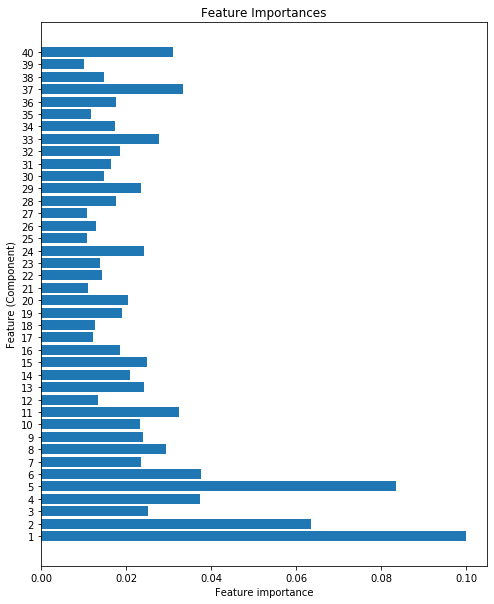

In [22]:
# Visualize feature importances
plot_feature_importances(forest)

The plot above shows that there are a few features that are a bit more powerful than the rest. A grid search (below) will help me determine if any of the less important features could be eliminated.

### Tune parameters with GridSearchCV

In [42]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [50, 100],
          'max_depth': [5, 10],
          'max_features': [20, 40]}

grid_forest = GridSearchCV(forest, params, cv=3, scoring='accuracy', n_jobs=-1)

grid_forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [43]:
# View best score and parameters
print('Best score:', grid_forest.best_score_)
print('Best params:', grid_forest.best_params_)

Best score: 0.8321042928627864
Best params: {'max_depth': 10, 'max_features': 20, 'n_estimators': 100}


In [44]:
# View the metrics for the best model
y_pred = grid_forest.predict(X_train)
print_metrics(y_train, y_pred)

Training accuracy: 0.8676774897475451
-------
Confusion matrix:
[[6076  998    2    0  215   17  286]
 [1242 5241  105    1  781  202   22]
 [   0   11 6223  262  183  915    0]
 [   0    0   34 7454    0  106    0]
 [  20  341  137    0 7043   53    0]
 [  12   36  491  111  122 6822    0]
 [ 327    0    0    0    2    0 7265]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.79      0.80      0.80      7594
           2       0.79      0.69      0.74      7594
           3       0.89      0.82      0.85      7594
           4       0.95      0.98      0.97      7594
           5       0.84      0.93      0.88      7594
           6       0.84      0.90      0.87      7594
           7       0.96      0.96      0.96      7594

    accuracy                           0.87     53158
   macro avg       0.87      0.87      0.87     53158
weighted avg       0.87      0.87      0.87     53158



In [45]:
# Check the model's score for the validation dataset
grid_forest.score(X_val, y_val)

0.184024371353333

### Evaluating the best Random Forest classifier

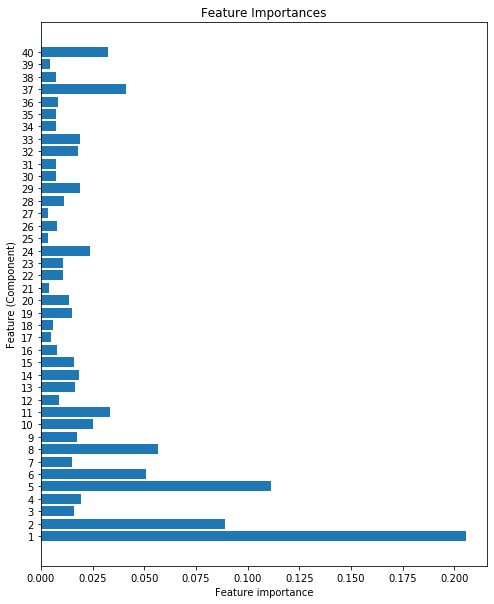

In [46]:
# Review feature importances for the model with the best parameters
forest_best = RandomForestClassifier(max_depth=10, max_features=20, 
                                     n_estimators=100)
forest_best.fit(X_train, y_train)

plot_feature_importances(forest_best)

In [47]:
# View metrics for the optimized model
y_pred = forest_best.predict(X_train)
print_metrics(y_train, y_pred)

Training accuracy: 0.8678656081869145
-------
Confusion matrix:
[[6061 1030    2    0  199    9  293]
 [1262 5225  105    1  778  197   26]
 [   0   12 6233  266  178  905    0]
 [   0    0   33 7450    0  111    0]
 [  14  346  103    0 7083   48    0]
 [  11   40  471  116  130 6826    0]
 [ 336    0    0    0    2    0 7256]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.79      0.80      0.79      7594
           2       0.79      0.69      0.73      7594
           3       0.90      0.82      0.86      7594
           4       0.95      0.98      0.97      7594
           5       0.85      0.93      0.89      7594
           6       0.84      0.90      0.87      7594
           7       0.96      0.96      0.96      7594

    accuracy                           0.87     53158
   macro avg       0.87      0.87      0.87     53158
weighted avg       0.87      0.87      0.87     53158



In [48]:
# Score the model on the validation set
forest_best.score(X_val, y_val)

0.18207948228085574

In [49]:
# View full metrics for the validation set
y_val_pred = forest_best.predict(X_val)
print_metrics(y_val, y_val_pred)

Training accuracy: 0.18207948228085574
-------
Confusion matrix:
[[ 9335     0     0     0     0     0 11849]
 [11464     0     0     0     0     0 16866]
 [ 1011     0     0     0     0     0  2564]
 [  105     0     0     0     0     0   170]
 [  268     0     0     0     0     0   682]
 [  469     0     0     0     0     0  1267]
 [  807     0     0     0     0     0  1244]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.40      0.44      0.42     21184
           2       0.00      0.00      0.00     28330
           3       0.00      0.00      0.00      3575
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       950
           6       0.00      0.00      0.00      1736
           7       0.04      0.61      0.07      2051

    accuracy                           0.18     58101
   macro avg       0.06      0.15      0.07     58101
weighted avg       0.15      0.18      0.15   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Find AUC and plot ROC curve
# y_score_forest = forest_best.fit(X_train, y_train).decision_function(X_test)

roc_it(y_test, y_score_forest)

## XGBoost

### Baseline model

In [0]:
xg = xgb.XGBClassifier()

In [35]:
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [36]:
y_pred = xg.predict(X_train)

print_metrics(y_train, y_pred)

Training accuracy: 0.7627262124233417
-------
Confusion matrix:
[[5395 1111    7    0  312   51  718]
 [1838 3979  168    3 1198  355   53]
 [   0    5 5186  706  273 1424    0]
 [   0    0  224 7195    0  175    0]
 [  95  555  271    0 6419  254    0]
 [   4   88 1563  445  212 5282    0]
 [ 476    3    0    0   26    0 7089]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.69      0.71      0.70      7594
           2       0.69      0.52      0.60      7594
           3       0.70      0.68      0.69      7594
           4       0.86      0.95      0.90      7594
           5       0.76      0.85      0.80      7594
           6       0.70      0.70      0.70      7594
           7       0.90      0.93      0.92      7594

    accuracy                           0.76     53158
   macro avg       0.76      0.76      0.76     53158
weighted avg       0.76      0.76      0.76     53158



In [37]:
xg.score(X_val, y_val)

0.03729712053148827

### Tune parameters with GridSearchCV

In [40]:
params = {'learning_rate': [0.01, 0.1],
          'n_estimators': [5, 30, 100]
}

grid_xgb = GridSearchCV(xg, params, scoring='accuracy', cv=3, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print('Best score:', grid_xgb.best_score_)
print('Best params:', grid_xgb.best_params_)

KeyboardInterrupt: ignored

In [0]:
y_pred = grid_xgb.predict(X_train)

print_metrics(y_train, y_pred)

In [0]:
grid_xgb.score(X_val, y_val)

### Evaluating the best XGBoost classifier

In [0]:
# Build the optimized model
# xgb_best = XGBClassifier() # insert best params
# xgb_best.fit(X_train, y_train)

In [0]:
# View metrics for the optimized model
# y_pred = xgb_best.predict(X_train)
# print_metrics(y_train, y_pred)

In [0]:
# Score the model on the validation set
# xgb_best.score(X_val_trans, y_val)

In [0]:
# View full metrics for the validation set
# y_val_pred = xgb_best.predict(X_val_trans)
# print_metrics(y_val, y_val_pred)

In [0]:
# Find AUC and plot ROC curve
# y_score_xg = xgb_best.fit(X_train, y_train).decision_function(X_test)

# roc_it(y_test, y_score_xg)

## Support Vector Machine

### Baseline model

In [0]:
# Build a baseline model
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svc.predict(X_train)
print_metrics(y_train, y_pred)

Training accuracy: 0.6421674055216609
-------
Confusion matrix:
[[4630 1731    9  281   61  800]
 [1710 4102  189 1206  323   41]
 [   0   28 4567  307 2713    0]
 [ 169 1486  691 5008  244    0]
 [   0  341 1985  472 4825    0]
 [1491    0   27    0    0 6129]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.58      0.62      0.60      7512
           2       0.53      0.54      0.54      7571
           3       0.61      0.60      0.61      7615
           5       0.69      0.66      0.67      7598
           6       0.59      0.63      0.61      7623
           7       0.88      0.80      0.84      7647

   micro avg       0.64      0.64      0.64     45566
   macro avg       0.65      0.64      0.64     45566
weighted avg       0.65      0.64      0.64     45566



In [0]:
svc.score(X_val, y_val)

0.6346558988764045

### Tune parameters with GridSearchCV

In [0]:
params = {'gamma': [0.1, 1.0, 100.0],
          'C': [0.1, 1.0, 10.0]}

grid_svc = GridSearchCV(svc, params, cv=3, scoring='accuracy')
grid_svc.fit(X_train, y_train)


print('Best score:', grid_svc.best_score_)
print('Best params:', grid_svc.best_params_)

KeyboardInterrupt: 

In [0]:
y_pred = grid_svc.predict(X_train)
print_metrics(y_train, y_pred)

In [0]:
grid_svc.score(X_val, y_val)

### Evaluating the best Support Vector classifier

In [0]:
# Build the optimized model
# svc_best = SVC() # insert best params
# svc_best.fit(X_train, y_train)

In [0]:
# View metrics for the optimized model
# y_pred = svc_best.predict(X_train)
# print_metrics(y_train, y_pred)

In [0]:
# Score the model on the validation set
# svc_best.score(X_val_trans, y_val)

In [0]:
# View full metrics for the validation set
# y_val_pred = svc_best.predict(X_val_trans)
# print_metrics(y_val, y_val_pred)

In [0]:
# Find AUC and plot ROC curve
# y_score_xg = svc_best.fit(X_train, y_train).decision_function(X_test)

# roc_it(y_test, y_score_xg)

# With SMOTE

In [0]:
# Use SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE

cover_4 = df[df.Cover_Type == 4]
sample_up = pd.concat([sample, cover_4], axis=0, ignore_index=True)

y_up = sample_up['Cover_Type']
X_up = sample_up.drop('Cover_Type', axis=1)

smote = SMOTE(random_state=1)
X_res, y_res = smote.fit_resample(X_up, y_up)


In [0]:
from collections import Counter
Counter(y_res)

Counter({1: 9493, 2: 9493, 3: 9493, 5: 9493, 6: 9493, 7: 9493, 4: 9493})

In [0]:
X_res_trans = pca.transform(X_res)

X_train, X_test, y_train, y_test = train_test_split(X_res_trans, y_res, 
                                                    test_size=0.2,
                                                    random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=0.5,
                                                random_state=2)

forest_best = RandomForestClassifier(max_depth=10, max_features=40, 
                                 n_estimators=150)
forest_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
y_pred = forest_best.predict(X_train)

print_metrics(y_train, y_pred)

Training accuracy: 0.8557562076749435
-------
Confusion matrix:
[[5435  831    9    0  293   15  981]
 [1168 4946  266    3  942  229  106]
 [   0   54 6114  376  116  868    0]
 [   0    0  119 7435    0   75    0]
 [   0   47  112    0 7365   67    0]
 [   0   29  416  262  138 6732    0]
 [ 133    9    0    0    4    0 7465]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.81      0.72      0.76      7564
           2       0.84      0.65      0.73      7660
           3       0.87      0.81      0.84      7528
           4       0.92      0.97      0.95      7629
           5       0.83      0.97      0.90      7591
           6       0.84      0.89      0.87      7577
           7       0.87      0.98      0.92      7611

   micro avg       0.86      0.86      0.86     53160
   macro avg       0.85      0.86      0.85     53160
weighted avg       0.85      0.86      0.85     53160



In [0]:
forest_best.score(X_val, y_val)

0.8209179834462002

# Interpretations and recommendations